In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV
from dca.cov_util import form_lag_matrix, calc_cross_cov_mats_from_data
import glob
import pdb
from statsmodels.tsa import stattools
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from pyuoi.linear_model.var import VAR

In [5]:
sys.path.append('/home/akumar/nse/neural_control')
from loaders import load_sabes
from decoders import lr_decoder
from utils import apply_df_filters

In [6]:
# Time scale analysis: 
# A few questions:
# (1) Use the subspaces derived at fast timescales to assess coupling/decoding at slower/the same timescales
# (2) Use subspaces derived at slow timeslcaes to assess coupling/decoding at same/faster time scales
# (3) Types of analyses:
# (a) Decoding vs. dim, decoding vs. t --> By "decoding" at slower timescales, we could try some kind of smoothing
# (b) Time-resolved CCA, look at the different populations of neurons

### Preprocess and save

In [5]:
# Select the indy data file that has both M1/S1 and one loco datafile that seems to give decent decoding performance
data_files = ['/mnt/Secondary/data/sabes/indy_20160426_01.mat', '/mnt/Secondary/data/sabes/loco_20170227_04.mat']

In [9]:

# Collect into bin width and filter param tuples

processing_params = [
    # Baseline - non-overlapping windows with no window
    (5, dict(filter_fn='none', filter_kwargs={})),
    (10, dict(filter_fn='none', filter_kwargs={})),
    (15, dict(filter_fn='none', filter_kwargs={})),
    (25, dict(filter_fn='none', filter_kwargs={})),
    (50, dict(filter_fn='none', filter_kwargs={})),

    # Narrow bins with smoothing timescales
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),


    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    # Narrow bins with boxcar filter of various widths
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),

    # Hann windows
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),
]

for didx, data_file in enumerate(data_files):
    for i, loader_param in tqdm(enumerate(processing_params)):
        if os.path.exists('/mnt/Secondary/data/sabes_tmp/didx_%d_loader_idx_%d.pkl' % (didx, i)):
            print('Skipping')
            continue
        else:
            print('Loading M1')
            datM1 = load_sabes(data_file, bin_width=loader_param[0], filter_fn=loader_param[1]['filter_fn'], filter_kwargs=loader_param[1]['filter_kwargs'], region='M1')
            print('Loading S1')
            datS1 = load_sabes(data_file, bin_width=loader_param[0], filter_fn=loader_param[1]['filter_fn'], filter_kwargs=loader_param[1]['filter_kwargs'], region='S1')

            # Save away with the loader parameters
            with open('/mnt/Secondary/data/sabes_tmp/didx_%d_loader_idx_%d.pkl' % (didx, i), 'wb') as f:
                f.write(pickle.dumps(datM1))
                f.write(pickle.dumps(datS1))
                f.write(pickle.dumps(loader_param))

0it [00:00, ?it/s]

Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Skipping
Loading M1
Loading S1
96


15it [03:36, 14.41s/it]

Loading M1
Loading S1
96


16it [07:12, 32.01s/it]

Loading M1
Loading S1
96


17it [10:47, 52.20s/it]

Loading M1
Loading S1
96


18it [12:35, 59.77s/it]

Loading M1
Loading S1
96


19it [14:23, 67.60s/it]

Loading M1
Loading S1
96


20it [16:11, 75.19s/it]

Loading M1
Loading S1
96


21it [16:54, 68.47s/it]

Loading M1
Loading S1
96


22it [17:37, 62.63s/it]

Loading M1
Loading S1
96


23it [18:22, 58.00s/it]

Loading M1
Loading S1
96


24it [21:56, 99.25s/it]

Loading M1
Loading S1
96


25it [25:30, 130.53s/it]

Loading M1
Loading S1
96


26it [29:05, 154.07s/it]

Loading M1
Loading S1
96


27it [30:52, 140.68s/it]

Loading M1
Loading S1
96


28it [32:39, 130.84s/it]

Loading M1
Loading S1
96


29it [34:27, 124.14s/it]

Loading M1
Loading S1
96


30it [35:10, 100.40s/it]

Loading M1
Loading S1
96


31it [35:54, 83.54s/it] 

Loading M1
Loading S1
96


32it [36:37, 68.68s/it]
0it [00:00, ?it/s]

Loading M1
Loading S1
96


1it [04:12, 252.28s/it]

Loading M1
Loading S1
96


2it [06:18, 178.21s/it]

Loading M1
Loading S1
96


3it [07:42, 135.23s/it]

Loading M1
Loading S1
96


4it [08:34, 102.31s/it]

Loading M1
Loading S1
96


5it [09:00, 74.64s/it] 

Loading M1
Loading S1
96


6it [13:15, 136.06s/it]

Loading M1
Loading S1
96


7it [17:30, 175.04s/it]

Loading M1
Loading S1
96


8it [21:47, 201.13s/it]

Loading M1
Loading S1
96


9it [23:55, 178.34s/it]

Loading M1
Loading S1
96


10it [26:04, 163.00s/it]

Loading M1
Loading S1
96


11it [28:13, 152.54s/it]

Loading M1
Loading S1
96


12it [29:05, 121.84s/it]

Loading M1
Loading S1
96


13it [29:57, 100.83s/it]

Loading M1
Loading S1
96


14it [30:49, 86.00s/it] 

Loading M1
Loading S1
96


15it [35:03, 136.79s/it]

Loading M1
Loading S1
96


16it [39:18, 172.28s/it]

Loading M1
Loading S1
96


17it [43:33, 197.21s/it]

Loading M1
Loading S1
96


18it [45:41, 176.41s/it]

Loading M1
Loading S1
96


19it [47:49, 161.90s/it]

Loading M1
Loading S1
96


20it [49:56, 151.38s/it]

Loading M1
Loading S1
96


21it [50:47, 121.33s/it]

Loading M1
Loading S1
96


22it [51:40, 100.65s/it]

Loading M1
Loading S1
96


23it [52:32, 86.15s/it] 

Loading M1
Loading S1
96


24it [56:46, 136.33s/it]

Loading M1
Loading S1
96


25it [1:00:59, 171.51s/it]

Loading M1
Loading S1
96


26it [1:05:14, 196.62s/it]

Loading M1
Loading S1
96


27it [1:07:21, 175.79s/it]

Loading M1
Loading S1
96


28it [1:09:29, 161.36s/it]

Loading M1
Loading S1
96


29it [1:11:38, 151.45s/it]

Loading M1
Loading S1
96


30it [1:12:29, 121.44s/it]

Loading M1
Loading S1
96


31it [1:13:21, 100.59s/it]

Loading M1
Loading S1
96


32it [1:14:13, 139.16s/it]


In [50]:

# Collect into bin width and filter param tuples

processing_params = [
    # Baseline - non-overlapping windows with no window
    (5, dict(filter_fn='none', filter_kwargs={})),
    (10, dict(filter_fn='none', filter_kwargs={})),
    (15, dict(filter_fn='none', filter_kwargs={})),
    (25, dict(filter_fn='none', filter_kwargs={})),
    (50, dict(filter_fn='none', filter_kwargs={})),

    # Narrow bins with smoothing timescales
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),


    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':1})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':5})),

    # Narrow bins with boxcar filter of various widths
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':10})),

    # Hann windows
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),


    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':5})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':10})),
]

for didx, data_file in enumerate(data_files):
    for i, loader_param in tqdm(enumerate(processing_params)):
        if os.path.exists('/mnt/Secondary/data/sabes_tmp/noboxcox/didx_%d_loader_idx_%d.pkl' % (didx, i)):
            print('Skipping')
            continue
        else:
            print('Loading M1')
            datM1 = load_sabes(data_file, bin_width=loader_param[0], 
                               filter_fn=loader_param[1]['filter_fn'], filter_kwargs=loader_param[1]['filter_kwargs'], region='M1', boxcox=None)
            print('Loading S1')
            datS1 = load_sabes(data_file, bin_width=loader_param[0], filter_fn=loader_param[1]['filter_fn'], 
                               filter_kwargs=loader_param[1]['filter_kwargs'], region='S1', boxcox=None)

            # Save away with the loader parameters
            with open('/mnt/Secondary/data/sabes_tmp/noboxcox/didx_%d_loader_idx_%d.pkl' % (didx, i), 'wb') as f:
                f.write(pickle.dumps(datM1))
                f.write(pickle.dumps(datS1))
                f.write(pickle.dumps(loader_param))

0it [00:00, ?it/s]

Loading M1
Loading S1
96


1it [00:22, 22.61s/it]

Loading M1
Loading S1
96


2it [00:34, 16.11s/it]

Loading M1
Loading S1
96


3it [00:42, 12.35s/it]

Loading M1
Loading S1
96


4it [00:47,  9.44s/it]

Loading M1
Loading S1
96


5it [00:49,  7.04s/it]

Loading M1
Loading S1
96


6it [01:12, 12.50s/it]

Loading M1
Loading S1
96


7it [01:36, 16.12s/it]

Loading M1
Loading S1
96


8it [02:00, 18.58s/it]

Loading M1
Loading S1
96


9it [02:12, 16.47s/it]

Loading M1
Loading S1
96


10it [02:24, 15.13s/it]

Loading M1
Loading S1
96


11it [02:36, 14.21s/it]

Loading M1
Loading S1
96


12it [02:41, 11.41s/it]

Loading M1
Loading S1
96


13it [02:46,  9.50s/it]

Loading M1
Loading S1
96


14it [02:51,  8.18s/it]

Loading M1
Loading S1
96


15it [03:14, 12.72s/it]

Loading M1
Loading S1
96


16it [03:38, 15.93s/it]

Loading M1
Loading S1
96


17it [04:01, 18.15s/it]

Loading M1
Loading S1
96


18it [04:13, 16.25s/it]

Loading M1
Loading S1
96


19it [04:25, 14.91s/it]

Loading M1
Loading S1
96


20it [04:37, 14.03s/it]

Loading M1
Loading S1
96


21it [04:42, 11.34s/it]

Loading M1
Loading S1
96


22it [04:47,  9.45s/it]

Loading M1
Loading S1
96


23it [04:52,  8.13s/it]

Loading M1
Loading S1
96


24it [05:15, 12.61s/it]

Loading M1
Loading S1
96


25it [05:38, 15.85s/it]

Loading M1
Loading S1
96


26it [06:02, 18.15s/it]

Loading M1
Loading S1
96


27it [06:14, 16.31s/it]

Loading M1
Loading S1
96


28it [06:26, 15.01s/it]

Loading M1
Loading S1
96


29it [06:38, 14.08s/it]

Loading M1
Loading S1
96


30it [06:43, 11.38s/it]

Loading M1
Loading S1
96


31it [06:48,  9.50s/it]

Loading M1
Loading S1
96


32it [06:53, 12.92s/it]
0it [00:00, ?it/s]

Loading M1
Loading S1
96


1it [00:33, 33.82s/it]

Loading M1
Loading S1
96


2it [00:50, 23.98s/it]

Loading M1
Loading S1
96


3it [01:02, 18.41s/it]

Loading M1
Loading S1
96


4it [01:09, 13.96s/it]

Loading M1
Loading S1
96


5it [01:13, 10.32s/it]

Loading M1
Loading S1
96


6it [01:48, 18.62s/it]

Loading M1
Loading S1
96


7it [02:23, 23.92s/it]

Loading M1
Loading S1
96


8it [02:58, 27.65s/it]

Loading M1
Loading S1
96


9it [03:16, 24.45s/it]

Loading M1
Loading S1
96


10it [03:33, 22.34s/it]

Loading M1
Loading S1
96


11it [03:51, 21.01s/it]

Loading M1
Loading S1
96


12it [03:59, 16.83s/it]

Loading M1
Loading S1
96


13it [04:06, 13.95s/it]

Loading M1
Loading S1
96


14it [04:14, 12.01s/it]

Loading M1
Loading S1
96


15it [04:48, 18.84s/it]

Loading M1
Loading S1
96


16it [05:23, 23.51s/it]

Loading M1
Loading S1
96


17it [05:57, 26.80s/it]

Loading M1
Loading S1
96


18it [06:14, 24.00s/it]

Loading M1
Loading S1
96


19it [06:32, 22.06s/it]

Loading M1
Loading S1
96


20it [06:49, 20.67s/it]

Loading M1
Loading S1
96


21it [06:57, 16.64s/it]

Loading M1
Loading S1
96


22it [07:04, 13.85s/it]

Loading M1
Loading S1
96


23it [07:11, 11.87s/it]

Loading M1
Loading S1
96


24it [07:46, 18.63s/it]

Loading M1
Loading S1
96


25it [08:20, 23.38s/it]

Loading M1
Loading S1
96


26it [08:55, 26.72s/it]

Loading M1
Loading S1
96


27it [09:12, 23.90s/it]

Loading M1
Loading S1
96


28it [09:30, 22.01s/it]

Loading M1
Loading S1
96


29it [09:47, 20.69s/it]

Loading M1
Loading S1
96


30it [09:54, 16.66s/it]

Loading M1
Loading S1
96


31it [10:02, 13.83s/it]

Loading M1
Loading S1
96


32it [10:09, 19.05s/it]


### Selection of useful loader params

In [45]:
processing_params = [
    # Baseline - non-overlapping windows with no window
    (5, dict(filter_fn='none', filter_kwargs={})),
    (10, dict(filter_fn='none', filter_kwargs={})),
    (25, dict(filter_fn='none', filter_kwargs={})),
    (50, dict(filter_fn='none', filter_kwargs={})),

    # Narrow bins with smoothing timescales
    (5, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (10, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    (25, dict(filter_fn='gaussian', filter_kwargs={'sigma':3})),
    # Narrow bins with boxcar filter of various widths
    (5, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (10, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
    (25, dict(filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})),
]

### Autocorrelations

In [15]:
# Analysis #1: Effective single neuron autocorrelation times

In [7]:
fls = glob.glob('/mnt/Secondary/data/sabes_tmp/*.pkl')

In [30]:
apply_df_filters(acfdf, didx=1, filter_fn='gaussian', filter_kwargs={'sigma':3})

,didx,bin_width,filter_fn,filter_kwargs,M1acf,S1acf,M1act,S1act
34,1,25,gaussian,{'sigma': 3},"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[13, 11, 10, 18, 22, 14, 32, 16, 14, 15, 24, 1...","[22, 10, 32, 10, 19, 37, 10, 11, 13, 10, 11, 1..."
57,1,5,gaussian,{'sigma': 3},"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[11, 11, 11, 28, 43, 11, 28, 12, 11, 12, 33, 1...","[13, 10, 12, 10, 11, 12, 10, 10, 11, 10, 11, 1..."
60,1,10,gaussian,{'sigma': 3},"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[12, 11, 10, 29, 34, 13, 32, 18, 13, 16, 33, 1...","[15, 10, 15, 10, 13, 18, 10, 10, 12, 10, 11, 1..."


In [ ]:
acfl = []
for fl in tqdm(fls):
    r = {}
    r['didx'] = int(fl.split('didx_')[1].split('_')[0])
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)
    r['bin_width'] = lparam[0]
    r['filter_fn'] = lparam[1]['filter_fn']
    r['filter_kwargs'] = lparam[1]['filter_kwargs']

    XM1 = datM1['spike_rates'].squeeze()
    m1acf = []
    for j in range(XM1.shape[1]):
        m1acf.append(stattools.acf(XM1[:, j]))
    
    m1acf = np.array(m1acf).T

    XS1 = datS1['spike_rates'].squeeze()
    s1acf = []
    for j in range(XS1.shape[1]):
        s1acf.append(stattools.acf(XS1[:, j]))
    
    s1acf = np.array(s1acf).T

    r['M1acf'] = m1acf
    r['S1acf'] = s1acf
    acfl.append(r) 

In [17]:
# Actually get the autocorrelation times
for r in acfl:
    acf = r['M1acf']
    act_index = [np.argwhere(acf[:, j] <= 5e-2 * acf[0, j]) for j in range(acf.shape[1])]
    act = np.array([aidx[0][0] if len(aidx > 0) else acf.shape[0] for aidx in act_index])
    r['M1act'] = act

    acf = r['S1acf']
    act_index = [np.argwhere(acf[:, j] <= 5e-2 * acf[0, j]) for j in range(acf.shape[1])]
    act = np.array([aidx[0][0] if len(aidx > 0) else acf.shape[0] for aidx in act_index])
    r['S1act'] = act

In [5]:
# with open('/home/akumar/nse/neural_control/data/timescales/acf.pkl', 'wb') as f:
#     f.write(pickle.dumps(acfl))
with open('/home/akumar/nse/neural_control/data/timescales/acf.pkl', 'rb') as f:
    acfl = pickle.load(f)

In [6]:
acfdf = pd.DataFrame(acfl)

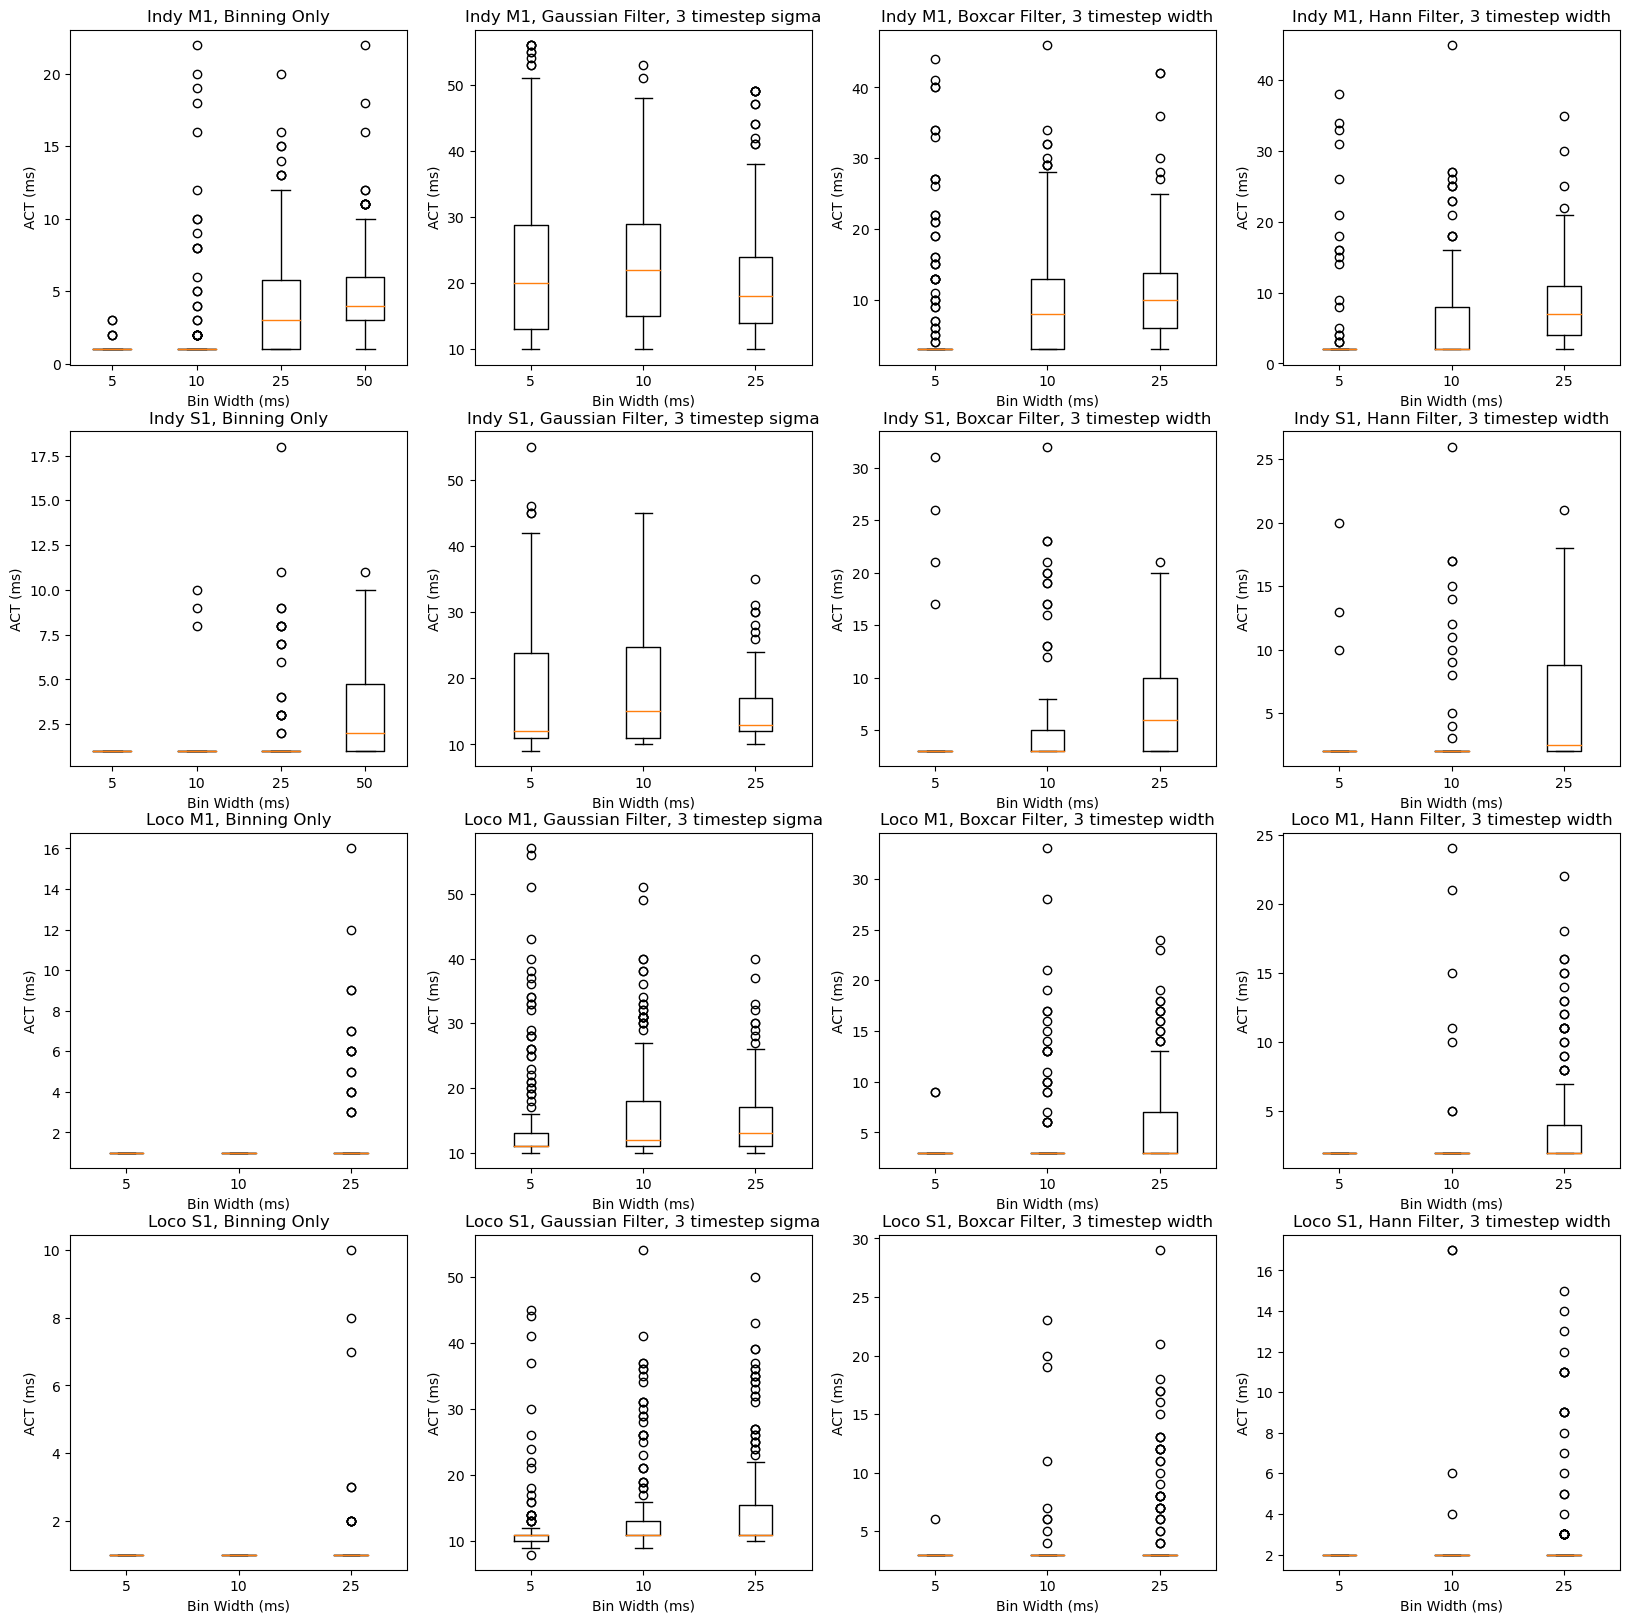

In [40]:
# Plot boxplots of the autocorrelation times induced by the various pre-processsing strategies for different bin sizes, across M1/S1 and for the different recording sessions

fig, ax = plt.subplots(4, 4, figsize=(20, 20))


##### No Filtering ######
df_ = apply_df_filters(acfdf, didx=0, filter_fn='none')
bin_widths = [5, 10, 25, 50]
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[0, 0].boxplot(m1act)
ax[0, 0].set_xticklabels(bin_widths)
ax[0, 0].set_xlabel('Bin Width (ms)')

ax[1, 0].boxplot(s1act)
ax[1, 0].set_xticklabels(bin_widths)
ax[1, 0].set_xlabel('Bin Width (ms)')

ax[0, 0].set_ylabel('ACT (ms)')
ax[1, 0].set_ylabel('ACT (ms)')
ax[0, 0].set_title('Indy M1, Binning Only')
ax[1, 0].set_title('Indy S1, Binning Only')

df_ = apply_df_filters(acfdf, didx=1, filter_fn='none')
bin_widths = [5, 10, 25]
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[2, 0].boxplot(m1act)
ax[2, 0].set_xticklabels(bin_widths)
ax[2, 0].set_xlabel('Bin Width (ms)')

ax[3, 0].boxplot(s1act)
ax[3, 0].set_xticklabels(bin_widths)
ax[3, 0].set_xlabel('Bin Width (ms)')


ax[2, 0].set_ylabel('ACT (ms)')
ax[3, 0].set_ylabel('ACT (ms)')
ax[2, 0].set_title('Loco M1, Binning Only')
ax[3, 0].set_title('Loco S1, Binning Only')

##### Gaussian Filtering ######
df_ = apply_df_filters(acfdf, didx=0, filter_fn='gaussian', filter_kwargs={'sigma':3})
bin_widths = [5, 10, 25]
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[0, 1].boxplot(m1act)
ax[0, 1].set_xticklabels(bin_widths)
ax[0, 1].set_xlabel('Bin Width (ms)')

ax[1, 1].boxplot(s1act)
ax[1, 1].set_xticklabels(bin_widths)
ax[1, 1].set_xlabel('Bin Width (ms)')

ax[0, 1].set_ylabel('ACT (ms)')
ax[1, 1].set_ylabel('ACT (ms)')
ax[0, 1].set_title('Indy M1, Gaussian Filter, 3 timestep sigma')
ax[1, 1].set_title('Indy S1, Gaussian Filter, 3 timestep sigma')


df_ = apply_df_filters(acfdf, didx=1, filter_fn='gaussian', filter_kwargs={'sigma':3})
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[2, 1].boxplot(m1act)
ax[2, 1].set_xticklabels(bin_widths)
ax[2, 1].set_xlabel('Bin Width (ms)')

ax[3, 1].boxplot(s1act)
ax[3, 1].set_xticklabels(bin_widths)
ax[3, 1].set_xlabel('Bin Width (ms)')

ax[2, 1].set_ylabel('ACT (ms)')
ax[3, 1].set_ylabel('ACT (ms)')
ax[2, 1].set_title('Loco M1, Gaussian Filter, 3 timestep sigma')
ax[3, 1].set_title('Loco S1, Gaussian Filter, 3 timestep sigma')


## Boxcar ##
df_ = apply_df_filters(acfdf, didx=0, filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})
bin_widths = [5, 10, 25]
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[0, 2].boxplot(m1act)
ax[0, 2].set_xticklabels(bin_widths)
ax[0, 2].set_xlabel('Bin Width (ms)')

ax[1, 2].boxplot(s1act)
ax[1, 2].set_xticklabels(bin_widths)
ax[1, 2].set_xlabel('Bin Width (ms)')


ax[0, 2].set_ylabel('ACT (ms)')
ax[1, 2].set_ylabel('ACT (ms)')
ax[0, 2].set_title('Indy M1, Boxcar Filter, 3 timestep width')
ax[1, 2].set_title('Indy S1, Boxcar Filter, 3 timestep width')


df_ = apply_df_filters(acfdf, didx=1, filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[2, 2].boxplot(m1act)
ax[2, 2].set_xticklabels(bin_widths)
ax[2, 2].set_xlabel('Bin Width (ms)')

ax[3, 2].boxplot(s1act)
ax[3, 2].set_xticklabels(bin_widths)
ax[3, 2].set_xlabel('Bin Width (ms)')

ax[2, 2].set_ylabel('ACT (ms)')
ax[3, 2].set_ylabel('ACT (ms)')
ax[2, 2].set_title('Loco M1, Boxcar Filter, 3 timestep width')
ax[3, 2].set_title('Loco S1, Boxcar Filter, 3 timestep width')

#### Hann #### 
df_ = apply_df_filters(acfdf, didx=0, filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})
bin_widths = [5, 10, 25]
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[0, 3].boxplot(m1act)
ax[0, 3].set_xticklabels(bin_widths)
ax[0, 3].set_xlabel('Bin Width (ms)')

ax[1, 3].boxplot(s1act)
ax[1, 3].set_xticklabels(bin_widths)
ax[1, 3].set_xlabel('Bin Width (ms)')

ax[0, 3].set_ylabel('ACT (ms)')
ax[1, 3].set_ylabel('ACT (ms)')
ax[0, 3].set_title('Indy M1, Hann Filter, 3 timestep width')
ax[1, 3].set_title('Indy S1, Hann Filter, 3 timestep width')

df_ = apply_df_filters(acfdf, didx=1, filter_fn='window', filter_kwargs={'window_name':'hann', 'window_length':3})
m1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['M1act'] for bw in bin_widths]
s1act = [df_.loc[df_['bin_width'] == bw].iloc[0]['S1act'] for bw in bin_widths]

ax[2, 3].boxplot(m1act)
ax[2, 3].set_xticklabels(bin_widths)
ax[2, 3].set_xlabel('Bin Width (ms)')

ax[3, 3].boxplot(s1act)
ax[3, 3].set_xticklabels(bin_widths)
ax[3, 3].set_xlabel('Bin Width (ms)')

ax[2, 3].set_ylabel('ACT (ms)')
ax[3, 3].set_ylabel('ACT (ms)')
ax[2, 3].set_title('Loco M1, Hann Filter, 3 timestep width')
ax[3, 3].set_title('Loco S1, Hann Filter, 3 timestep width')

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/acf.pdf', bbox_inches='tight', pad_inches=0)

In [38]:
# Narrow to none --> boxcar --> gaussian

In [6]:
# Analysis 2: Cross-correlations between M1/S1 neurons
ccfl = []
for fl in tqdm(fls):
    r = {}
    r['didx'] = int(fl.split('didx_')[1].split('_')[0])
    with open(fl, 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)
    r['bin_width'] = lparam[0]
    r['filter_fn'] = lparam[1]['filter_fn']
    r['filter_kwargs'] = lparam[1]['filter_kwargs']

    XM1 = datM1['spike_rates'].squeeze()
    XS1 = datS1['spike_rates'].squeeze()

    x = np.hstack([XM1, XS1])
    ccm = calc_cross_cov_mats_from_data(x, 30, chunks=10)
    r['ccf'] = ccm
    ccfl.append(r) 

100%|██████████| 64/64 [1:59:04<00:00, 111.64s/it]


In [9]:
# with open('/home/akumar/nse/neural_control/data/timescales/ccf.pkl', 'wb') as f:
#     f.write(pickle.dumps(ccfl))
with open('/home/akumar/nse/neural_control/data/timescales/ccf.pkl', 'rb') as f:
    ccfl = pickle.load(f)

EOFError: Ran out of input

### Canonical Correlation Coefficients and S1 -> CC R2

#### Consolidating

In [6]:
# CCA across timescales
fls = glob.glob('/mnt/Secondary/data/mpi_cc/*.pkl')

In [7]:
rl = []
for fl in fls:
    with open(fl, 'rb') as f:
        while True:
            try:
                result = pickle.load(f)
                rl.append(result)
            except (EOFError):
                break

In [8]:
df = pd.DataFrame(rl)

In [176]:
# Get the canonical correlation coefficients.
cc_coefs = np.zeros((df.shape[0], 6))
r2_scores = np.zeros(df.shape[0])
# These are the 

for i in range(df.shape[0]):
    print(i)
    with open(df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = df.iloc[i]['lag']
    w = df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)


    model = df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)
    ccc2 = np.array([scipy.stats.pearsonr(X_c[:, j], Y_c[:, j])[0] for j in range(X_c.shape[1])])    
    cc_coefs[i, :] = ccc2
    r2_scores[i] = model.score(x, y)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [177]:
df['cc_coefs'] = list(cc_coefs)
df['r2_scores'] = list(r2_scores)

In [178]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df.pkl', 'wb') as f:
    f.write(pickle.dumps(df))

#### Plotting

In [18]:
with open('/mnt/Secondary/data/postprocessed/cca_timescales_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [19]:
lags = list(np.unique(df['lag'].values))
windows = list(np.unique(df['win'].values))

In [20]:
dfvalid1 = apply_df_filters(df, filter_fn='none', bin_width=[5, 10, 25])
dfvalid2 = apply_df_filters(df, filter_fn='gaussian', filter_kwargs={'sigma': 3})
dfvalid3 = apply_df_filters(df, filter_fn='window', filter_kwargs={'window_name':'boxcar', 'window_length':3})

In [10]:
dfvalid = pd.concat([dfvalid1, dfvalid2, dfvalid3])

In [11]:
dfvalid.shape

(162, 10)

In [20]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1, filter_fn='gaussian')
ccc_act_pairs = np.zeros((2, w1df.shape[0]//2, 3))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j)
    for i in range(w1dfd.shape[0]):
        ccc = np.max(w1dfd.iloc[i]['cc_coefs'])
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        ccc_act_pairs[j, i, 0] = ccc
        ccc_act_pairs[j, i, 1] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        ccc_act_pairs[j, i, 2] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))

        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])
#        cols2.append(lag_cols[windows.index(w1dfd.iloc[i]['win'])])



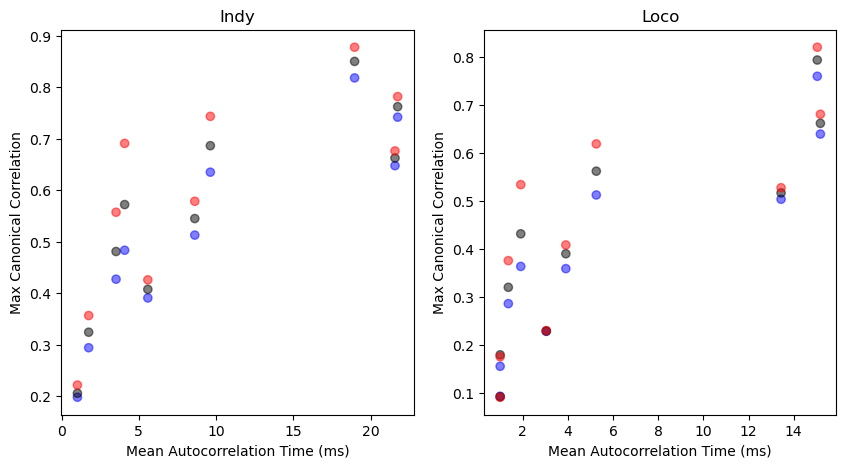

In [25]:
# Additionally color code by lag/window size combinations
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0].scatter(ccc_act_pairs[0, :, 1], ccc_act_pairs[0, :, 0], c=cols1[0], alpha=0.5)
ax[1].scatter(ccc_act_pairs[1, :, 1], ccc_act_pairs[1, :, 0], c=cols1[0], alpha=0.5)
ax[0].set_ylabel('Max Canonical Correlation')
ax[1].set_ylabel('Max Canonical Correlation')
ax[0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0].set_title('Indy')
ax[1].set_title('Loco')
fig.savefig('/home/akumar/nse/neural_control/figs/timescales/cc_coef.pdf', bbox_inches='tight',  pad_inches=0)

#### Direct regression calculation

In [193]:
# What is the raw r2 of prediction across the different preprocesing parameters? CCA doesn't do very well, because we try to compress down to 6 dimensions. Let's just do ambient regression. This dovetails nicely
# with a poisson GLM regressiona

In [13]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [14]:
# Use L1OCV Ridge and re-do these calculations

In [15]:
w1df = apply_df_filters(dfvalid, win=1)
lr2 = np.zeros((w1df.shape[0], 5))

for i in tqdm(range(w1df.shape[0])):
    with open(w1df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = w1df.iloc[i]['lag']
    w = w1df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)

    x = StandardScaler().fit_transform(x)
    y = StandardScaler().fit_transform(y)

    for j, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(x)):

        linmodel = RidgeCV()
        linmodel.fit(x[train_idxs], y[train_idxs])

        xtest = x[test_idxs]
        ytest = y[test_idxs]
        lr2[i, j] = linmodel.score(xtest, ytest)

100%|██████████| 54/54 [07:58<00:00,  8.85s/it]


In [16]:
lr2_cc = np.zeros((df.shape[0], 5, 6))

for i in tqdm(range(w1df.shape[0])):
    with open(w1df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = w1df.iloc[i]['lag']
    w = w1df.iloc[i]['win']


    # Apply window and lag relative to each other
    if lag != 0:
        x = X[:-lag, :]
        y = Y[lag:, :]
    else:
        x = X
        y = Y

    if w > 1:
        x = form_lag_matrix(x, w)
        y = form_lag_matrix(y, w)

    model = w1df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)

    x = StandardScaler().fit_transform(x)
    for d in range(1, 7):
        y = StandardScaler().fit_transform(Y_c)[:, 0:d]        

        for j, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5).split(x)):

            linmodel = RidgeCV()
            linmodel.fit(x[train_idxs], y[train_idxs])
            xtest = x[test_idxs]
            ytest = y[test_idxs]
    
            lr2_cc[i, j, d-1] = linmodel.score(xtest, ytest)

100%|██████████| 54/54 [20:31<00:00, 22.80s/it]


In [17]:
# with open('m1s1_regression.dat', 'wb') as f:
#     f.write(pickle.dumps(lr2))
#     f.write(pickle.dumps(lr2_cc))
with open('m1s1_regression.dat', 'rb') as f:
    lr2 = pickle.load(f)
    lr2_cc = pickle.load(f)

In [24]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
r2_act_pairs = np.zeros((2, w1df.shape[0]//2, 3))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    print(w1dfd.index)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        r2_act_pairs[j, i, 0] = np.mean(lr2[w1dfd.index[i]])
        r2_act_pairs[j, i, 1] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        r2_act_pairs[j, i, 2] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))

        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])
#        cols2.append(lag_cols[windows.index(w1dfd.iloc[i]['win'])])



Int64Index([ 0,  1,  2,  6,  7,  8, 12, 13, 14, 18, 19, 20, 21, 22, 23, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
           dtype='int64')
Int64Index([ 3,  4,  5,  9, 10, 11, 15, 16, 17, 24, 25, 26, 27, 28, 29, 30, 31,
            32, 45, 46, 47, 48, 49, 50, 51, 52, 53],
           dtype='int64')


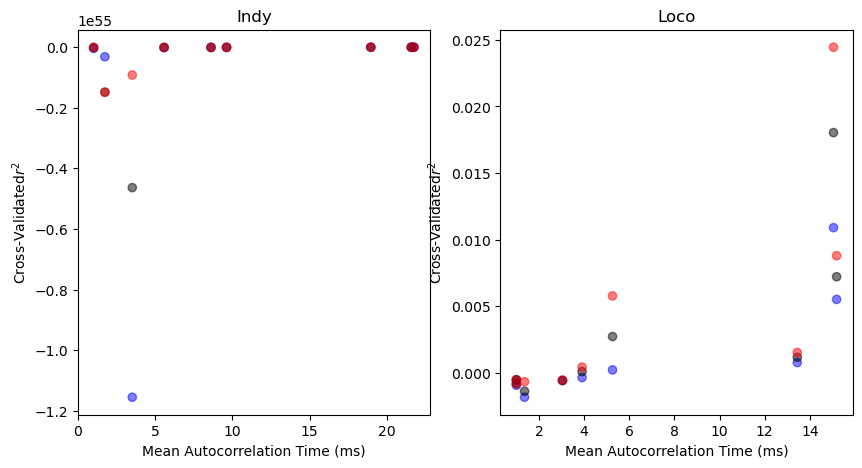

In [25]:
# Additionally color code by lag/window size combinations
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# r2_act_pairs[r2_act_pairs < -2] = np.nan

ax[0].scatter(r2_act_pairs[0, :, 1], r2_act_pairs[0, :, 0], c=cols1[0], alpha=0.5)
ax[1].scatter(r2_act_pairs[1, :, 1], r2_act_pairs[1, :, 0], c=cols1[0], alpha=0.5)
ax[0].set_ylabel('Cross-Validated' + r'$r^2$')
ax[1].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0].set_title('Indy')
ax[1].set_title('Loco')
fig.savefig('/home/akumar/nse/neural_control/figs/timescales/s1m1r2.pdf', bbox_inches='tight',  pad_inches=0)

In [ ]:
# Project the M1 data onto the most predictable direction...
# How does one do that? Project onto top CCA vectors?

In [26]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
r2_act_pairs = np.zeros((2, w1df.shape[0]//2, 3))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    print(w1dfd.index)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        r2_act_pairs[j, i, 0] = np.mean(lr2_cc[w1dfd.index[i], :, 1])
        r2_act_pairs[j, i, 1] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        r2_act_pairs[j, i, 2] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))

        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])

Int64Index([ 0,  1,  2,  6,  7,  8, 12, 13, 14, 18, 19, 20, 21, 22, 23, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
           dtype='int64')
Int64Index([ 3,  4,  5,  9, 10, 11, 15, 16, 17, 24, 25, 26, 27, 28, 29, 30, 31,
            32, 45, 46, 47, 48, 49, 50, 51, 52, 53],
           dtype='int64')


In [56]:
r2_act_pairs.shape

(2, 30, 3)

In [59]:
r2_act_pairs[0, :, 0]

array([0.0226651 , 0.02431   , 0.02770665, 0.00545844, 0.00536478,
       0.00527676, 0.05300787, 0.06348709, 0.07467927, 0.01680801,
       0.0208551 , 0.02074643, 0.11944275, 0.15018261, 0.19510693,
       0.05995042, 0.07355582, 0.09458161, 0.16462552, 0.22545524,
       0.32360739, 0.10434634, 0.1421998 , 0.20607247, 0.56525554,
       0.61221708, 0.65327238, 0.29926244, 0.31120795, 0.32255143])

In [58]:
np.argmax(r2_act_pairs[0, :, 1])

18

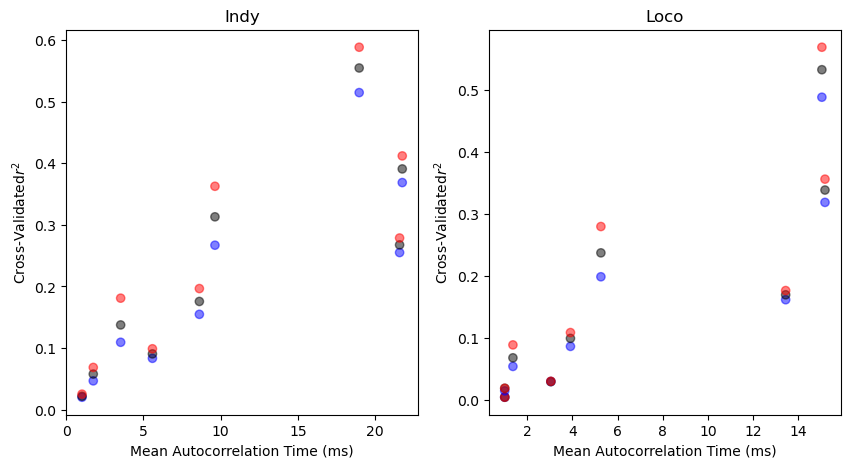

In [27]:
# Additionally color code by lag/window size combinations
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

r2_act_pairs[r2_act_pairs < -1] = np.nan

ax[0].scatter(r2_act_pairs[0, :, 1], r2_act_pairs[0, :, 0], c=cols1[0], alpha=0.5)
ax[1].scatter(r2_act_pairs[1, :, 1], r2_act_pairs[1, :, 0], c=cols1[0], alpha=0.5)
ax[0].set_ylabel('Cross-Validated' + r'$r^2$')
ax[1].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0].set_title('Indy')
ax[1].set_title('Loco')
fig.savefig('/home/akumar/nse/neural_control/figs/timescales/s1m1r2_cc.pdf', bbox_inches='tight',  pad_inches=0)

In [60]:
np.max(lr2_cc, axis=0)

array([0.86040743, 0.82433279, 0.75909007, 0.71321485, 0.67521948,
       0.63765622])

In [ ]:
# Which preprocessing parameters are responsible for the really bad regression?

### Subspace analysis

In [ ]:
# predictability monotonically decreases

In [61]:
# One queston one should resolve is whether the most predictable direction is given by CCA. In the communication subspace paper, one uses factor analysis to
# resolve this question, but this is geared towards explanations of variance

In [62]:
# Subsequent question: What is the subspace angle relationship of the canonical correlation vectors to the subspace methods? 
# How predictable are the subspace dynamics (linearly, or GLM) from S1 activity?

In [13]:
argfiles = glob.glob('/mnt/Secondary/data/timescale_dimreduc/arg*dat')

In [14]:
rl = []
for argfile in argfiles:
    with open(argfile, 'rb') as f:
        args = pickle.load(f)
    argno = argfile.split('arg')[1].split('.dat')[0]
    r = {}
    r['rf'] = args['results_file']
    r['data_file'] = args['data_file']
    r['dr_method'] = args['task_args']['dimreduc_method']
    r['dr_args'] = args['task_args']['dimreduc_args']
    rl.append(r)

In [47]:
df_1 = apply_df_filters(df, filter_fn='none', bin_width=50, didx=0)
df_2 = apply_df_filters(df, filter_fn='none', bin_width=50, didx=1)

rl1 = apply_df_filters(ref_df, dr_method='PCA', data_file=df_1.iloc[0]['fl'])
rl2 = apply_df_filters(ref_df, dr_method='PCA', data_file=df_2.iloc[0]['fl'])
rl3 = apply_df_filters(ref_df, dr_method='LQGCA', data_file=df_1.iloc[0]['fl'], dr_args={'T':3, 'loss_type':'trace', 'n_init':10})
rl4 = apply_df_filters(ref_df, dr_method='LQGCA', data_file=df_2.iloc[0]['fl'], dr_args={'T':3, 'loss_type':'trace', 'n_init':10})

In [40]:
# Is the 50 ms bin width present?
rl.iloc[0]
rl.iloc[0]['rf']

'/mnt/Secondary/data/timescale_dimreduc/timescale_dimreduc_103.dat'

In [56]:
with open(rl3.iloc[0]['rf'], 'rb') as f:
    r = pickle.load(f)

In [33]:
# Use the ref_df to answer the following questions:
# (1) What is the subspace angle relationship between the subspace methods and the top canonical correlation vectors?
# (2) How predictable are the subspaces from the S1 activity?

In [35]:
# Restrict to window length 1
dfw1 = apply_df_filters(dfvalid, win=1)

# N unique cca fits x dr types x folds x dims
ssa_avg = np.zeros((dfw1.shape[0], 4, 5, 3))
ssa_min = np.zeros((dfw1.shape[0], 4, 5, 3))

for i in tqdm(range(dfw1.shape[0])):
    with open(dfw1.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()

    lag = dfw1.iloc[i]['lag']
    w = dfw1.iloc[i]['win']

    model = dfw1.iloc[i]['ccamodel']

    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)

    Vcca = model.y_weights_

    if len(drdf) > 0:
        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                try:
                    d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                except:
                    pdb.set_trace()
                assert(d_.shape[0] == 1)
                Vpca = d_.iloc[0]['coef']
                ssangles = scipy.linalg.subspace_angles(Vpca, Vcca)
                ssa_avg[i, 0, fold, didx] = np.mean(ssangles)
                ssa_min[i, 0, fold, didx] = np.min(ssangles)

    else:
        ssa_avg[i, 0] = np.nan
        ssa_min[i, 0] = np.nan

    lqgdf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='LQGCA')
    assert(lqgdf.shape[0] == 3)

    # Keep consistent ordering of dimreduc args
    drargs = [{'T':3, 'loss_type':'trace', 'n_init':10}, {'T':1, 'loss_type':'trace', 'n_init':10},
              {'T':6, 'loss_type':'trace', 'n_init':10}]

    for j in range(3): 
        lqgdf_ = apply_df_filters(lqgdf, dr_args=drargs[j])
        with open(lqgdf_.iloc[0]['rf'], 'rb') as f:
            results = pickle.load(f)

        drdf = pd.DataFrame(results)

        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                try:
                    d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                    Vlqg = d_.iloc[0]['coef']
                    ssangles = scipy.linalg.subspace_angles(Vlqg, Vcca)
                    ssa_avg[i, j + 1, fold, didx] = np.mean(ssangles)
                    ssa_min[i, j + 1, fold, didx] = np.min(ssangles)    
                except:
                    ssa_avg[i, j + 1, fold, didx] = np.nan
                    ssa_min[i, j + 1, fold, didx] = np.nan    
            

100%|██████████| 60/60 [00:41<00:00,  1.43it/s]


In [43]:
# Restrict to window length 1
dfw1 = apply_df_filters(dfvalid, win=1)

# N unique cca fits x dr types x folds x dims
method_ssa_avg = np.zeros((dfw1.shape[0], 5, 3))
method_ssa_min = np.zeros((dfw1.shape[0], 5, 3))

for i in tqdm(range(dfw1.shape[0])):
    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf_pca = pd.DataFrame(results)
    lqgdf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='LQGCA', dr_args={'T':3, 'loss_type':'trace', 'n_init':10})
    assert(lqgdf.shape[0] == 1)
    with open(lqgdf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)
    drdf_lqg = pd.DataFrame(results)

    if len(drdf_pca) > 0 and len(drdf_lqg) > 0:
        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):

                d_pca = apply_df_filters(drdf_pca, dim=dim, fold_idx=fold)
                d_lqg = apply_df_filters(drdf_lqg, dim=dim, fold_idx=fold)
                assert(d_pca.shape[0] == 1)
                assert(d_lqg.shape[0] == 1)
                Vpca = d_pca.iloc[0]['coef']
                Vlqg = d_lqg.iloc[0]['coef']

                ssangles = scipy.linalg.subspace_angles(Vpca, Vlqg)
                method_ssa_avg[i, fold, didx] = np.mean(ssangles)
                method_ssa_min[i, fold, didx] = np.min(ssangles)

    else:
        method_ssa_avg[i] = np.nan
        method_ssa_min[i] = np.nan

100%|██████████| 60/60 [00:08<00:00,  6.72it/s]


In [97]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
ssa_act_pairs = np.zeros((2, w1df.shape[0]//2, 8))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    print(w1dfd.index)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], 
                                   filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        ssa_act_pairs[j, i, 0] = np.nanmean(ssa_avg[w1dfd.index[i], 0, :, 2])
        ssa_act_pairs[j, i, 1] = np.nanmean(ssa_min[w1dfd.index[i], 0, :, 2])

        ssa_act_pairs[j, i, 2] = np.nanmean(ssa_avg[w1dfd.index[i], 1, :, 2])
        ssa_act_pairs[j, i, 3] = np.nanmean(ssa_min[w1dfd.index[i], 1, :, 2])

        ssa_act_pairs[j, i, 4] = np.nanmean(method_ssa_avg[w1dfd.index[i], :, 2])
        ssa_act_pairs[j, i, 5] = np.nanmean(method_ssa_min[w1dfd.index[i], :, 2])

        ssa_act_pairs[j, i, 6] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        ssa_act_pairs[j, i, 7] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))

        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])

Int64Index([ 0,  1,  2,  6,  7,  8, 12, 13, 14, 18, 19, 20, 24, 25, 26, 27, 28,
            29, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
           dtype='int64')
Int64Index([ 3,  4,  5,  9, 10, 11, 15, 16, 17, 21, 22, 23, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 51, 52, 53, 54, 55, 56, 57, 58, 59],
           dtype='int64')


/tmp/ipykernel_14321/1388019896.py:19: RuntimeWarning: Mean of empty slice
  ssa_act_pairs[j, i, 0] = np.nanmean(ssa_avg[w1dfd.index[i], 0, :, 2])
/tmp/ipykernel_14321/1388019896.py:20: RuntimeWarning: Mean of empty slice
  ssa_act_pairs[j, i, 1] = np.nanmean(ssa_min[w1dfd.index[i], 0, :, 2])
/tmp/ipykernel_14321/1388019896.py:22: RuntimeWarning: Mean of empty slice
  ssa_act_pairs[j, i, 2] = np.nanmean(ssa_avg[w1dfd.index[i], 1, :, 2])
/tmp/ipykernel_14321/1388019896.py:23: RuntimeWarning: Mean of empty slice
  ssa_act_pairs[j, i, 3] = np.nanmean(ssa_min[w1dfd.index[i], 1, :, 2])
/tmp/ipykernel_14321/1388019896.py:25: RuntimeWarning: Mean of empty slice
  ssa_act_pairs[j, i, 4] = np.nanmean(method_ssa_avg[w1dfd.index[i], :, 2])
/tmp/ipykernel_14321/1388019896.py:26: RuntimeWarning: Mean of empty slice
  ssa_act_pairs[j, i, 5] = np.nanmean(method_ssa_min[w1dfd.index[i], :, 2])


In [40]:
# Boxplot average/min subspace angle as a function fo autocorrelation time... --> CCA with PCA,LQG, PCA vs. LQG (3 parallel boxplots)

(60, 4, 5, 3)

In [47]:
ssa_act_pairs.shape

(2, 30, 8)

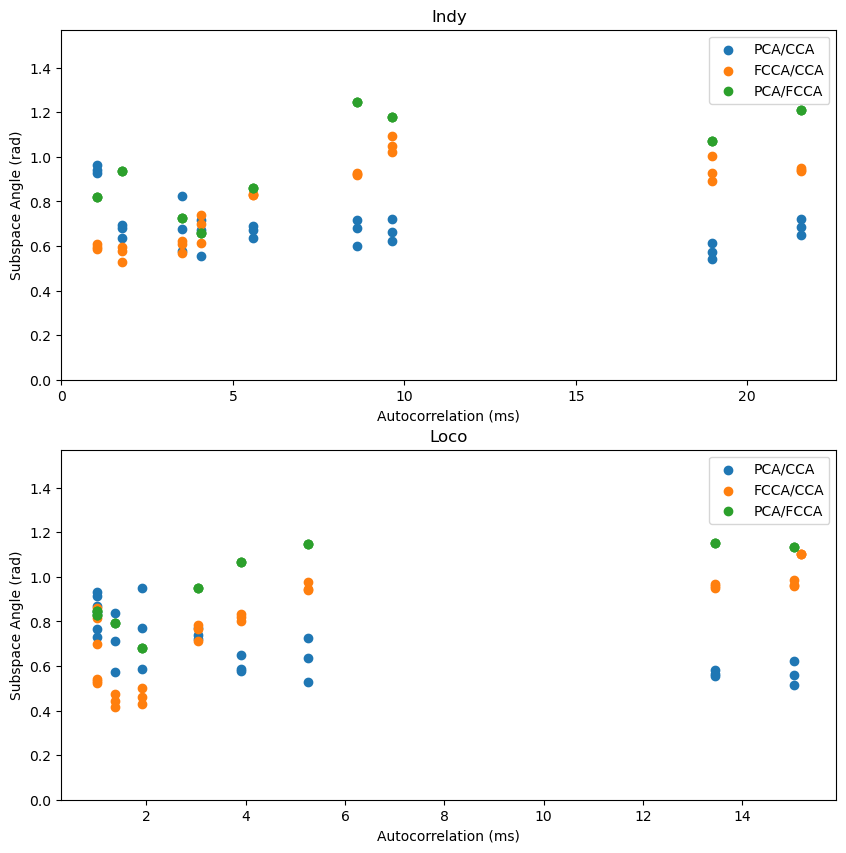

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# xvals = 5 * ssa_act_pairs[0, :, 6]
# ax[0].bar(xvals, ssa_act_pairs[0, :, 0], alpha=0.5)
# ax[0].bar(xvals - 1, ssa_act_pairs[0, :, 2], alpha=0.5)
# ax[0].bar(xvals + 1, ssa_act_pairs[0, :, 4], alpha=0.5)
# ax[0].set_xticklabels(ssa_act_pairs[0, :, 6])
# ax[0].set_xlabel('Increasing autocorrelation -->')
# ax[0].set_title('Indy')

# xvals = 5 * ssa_act_pairs[1, :, 6]
# ax[1].bar(xvals, ssa_act_pairs[1, :, 0], alpha=0.5)
# ax[1].bar(xvals - 1, ssa_act_pairs[1, :, 2], alpha=0.5)
# ax[1].bar(xvals + 1, ssa_act_pairs[1, :, 4], alpha=0.5)

ax[0].scatter(ssa_act_pairs[0, :, 6], ssa_act_pairs[0, :, 1])
ax[0].scatter(ssa_act_pairs[0, :, 6], ssa_act_pairs[0, :, 3])
ax[0].scatter(ssa_act_pairs[0, :, 6], ssa_act_pairs[0, :, 5])
ax[0].set_ylim([0, np.pi/2])
ax[0].set_title('Indy')
ax[0].set_xlabel('Autocorrelation (ms)')
ax[0].set_ylabel('Subspace Angle (rad)')
ax[0].legend(['PCA/CCA', 'FCCA/CCA', 'PCA/FCCA'])


ax[1].scatter(ssa_act_pairs[1, :, 6], ssa_act_pairs[1, :, 1])
ax[1].scatter(ssa_act_pairs[1, :, 6], ssa_act_pairs[1, :, 3])
ax[1].scatter(ssa_act_pairs[1, :, 6], ssa_act_pairs[1, :, 5])
ax[1].set_ylim([0, np.pi/2])
ax[1].set_title('Loco')
ax[1].set_xlabel('Autocorrelation (ms)')
ax[1].set_ylabel('Subspace Angle (rad)')
ax[1].legend(['PCA/CCA', 'FCCA/CCA', 'PCA/FCCA'])

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/subspace_angles.pdf', bbox_inches='tight', pad_inches=0)

In [74]:
# For dimensions 2-6, perform a cross-validated regression from S1 activity to the projected activity of each of the methods.
# This has no interaction with cca. Therefore, remove the iteration over windows

# N unique cca fits x dr types x folds x dims
dfw1 = apply_df_filters(dfvalid, win=1)
subspace_r2 = np.zeros((dfw1.shape[0], 4, 5, 3))

for i in tqdm(range(dfw1.shape[0])):
    with open(dfw1.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    Y = datM1['spike_rates'].squeeze()
    X = datS1['spike_rates'].squeeze()
    lag = dfw1.iloc[i]['lag']
    w = dfw1.iloc[i]['win']

    model = dfw1.iloc[i]['ccamodel']

    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)

    Vcca = model.y_weights_

    # For each fold, and dimensions 2-6, measure the min and average subspace angle
    for fold in range(5):
        for didx, dim in enumerate(np.array([2, 4, 6])):
            try:
                d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                assert(d_.shape[0] == 1)
            except:
                subspace_r2[i, 0, fold, didx] = np.nan
                continue

            Vpca = d_.iloc[0]['coef']

            ytrain = Y[d_.iloc[0]['train_idxs']] @ Vpca
            ytest = Y[d_.iloc[0]['test_idxs']] @ Vpca

            xtrain = X[d_.iloc[0]['train_idxs']]
            xtest = X[d_.iloc[0]['test_idxs']]

            # Apply window and lag relative to each other
            if lag != 0:
                xtrain = xtrain[:-lag, :]
                ytrain = ytrain[lag:, :]

                xtest = xtest[:-lag, :]
                ytest = ytest[lag:, :]

            ytrain = StandardScaler().fit_transform(ytrain)
            xtrain = StandardScaler().fit_transform(xtrain)

            ytest = StandardScaler().fit_transform(ytest)
            xtest = StandardScaler().fit_transform(xtest)

            linmodel = RidgeCV()
            linmodel.fit(xtrain, ytrain)
            subspace_r2[i, 0, fold, didx] = linmodel.score(xtest, ytest)

    lqgdf = apply_df_filters(ref_df, data_file=dfw1.iloc[i]['fl'], dr_method='LQGCA')
    assert(lqgdf.shape[0] == 3)

    # Keep consistent ordering of dimreduc args
    drargs = [{'T':3, 'loss_type':'trace', 'n_init':10}, {'T':1, 'loss_type':'trace', 'n_init':10},
              {'T':6, 'loss_type':'trace', 'n_init':10}]

    for j in range(3): 
        lqgdf_ = apply_df_filters(lqgdf, dr_args=drargs[j])
        with open(lqgdf_.iloc[0]['rf'], 'rb') as f:
            results = pickle.load(f)

        drdf = pd.DataFrame(results)
        for fold in range(5):
            for didx, dim in enumerate(np.array([2, 4, 6])):
                try:
                    d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                    assert(d_.shape[0] == 1)
                except:
                    subspace_r2[i, j + 1, fold, didx] = np.nan
                    continue

                Vlqg = d_.iloc[0]['coef']

                ytrain = Y[d_.iloc[0]['train_idxs']] @ Vlqg
                ytest = Y[d_.iloc[0]['test_idxs']] @ Vlqg

                xtrain = X[d_.iloc[0]['train_idxs']]
                xtest = X[d_.iloc[0]['test_idxs']]

                # Apply window and lag relative to each other
                if lag != 0:
                    xtrain = xtrain[:-lag, :]
                    ytrain = ytrain[lag:, :]

                    xtest = xtest[:-lag, :]
                    ytest = ytest[lag:, :]

                ytrain = StandardScaler().fit_transform(ytrain)
                xtrain = StandardScaler().fit_transform(xtrain)

                ytest = StandardScaler().fit_transform(ytest)
                xtest = StandardScaler().fit_transform(xtest)

                linmodel = RidgeCV()
                linmodel.fit(xtrain, ytrain)    
                subspace_r2[i, j + 1, fold, didx] = linmodel.score(xtest, ytest)

    # For dimensions 2-6, perform a cross-validated regression from S1 activity to the projected activity of each of the methods.
    # This has no interaction with cca
    

100%|██████████| 60/60 [1:06:05<00:00, 66.09s/it]


In [31]:
# with open('s1_subspace_regression.pkl', 'wb') as f:
#     f.write(pickle.dumps(subspace_r2))
with open('s1_subspace_regression.pkl', 'rb') as f:
    subspace_r2 = pickle.load(f)

In [32]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
sr2_act_pairs = np.zeros((2, w1df.shape[0]//2, 6))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        sr2_act_pairs[j, i, 0] = np.mean(subspace_r2[w1dfd.index[i], :, 0, 0])
        sr2_act_pairs[j, i, 1] = np.mean(subspace_r2[w1dfd.index[i], :, 1, 0])
        sr2_act_pairs[j, i, 2] = np.mean(subspace_r2[w1dfd.index[i], :, 2, 0])
        sr2_act_pairs[j, i, 3] = np.mean(subspace_r2[w1dfd.index[i], :, 3, 0])
        sr2_act_pairs[j, i, 4] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        sr2_act_pairs[j, i, 5] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))

        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])

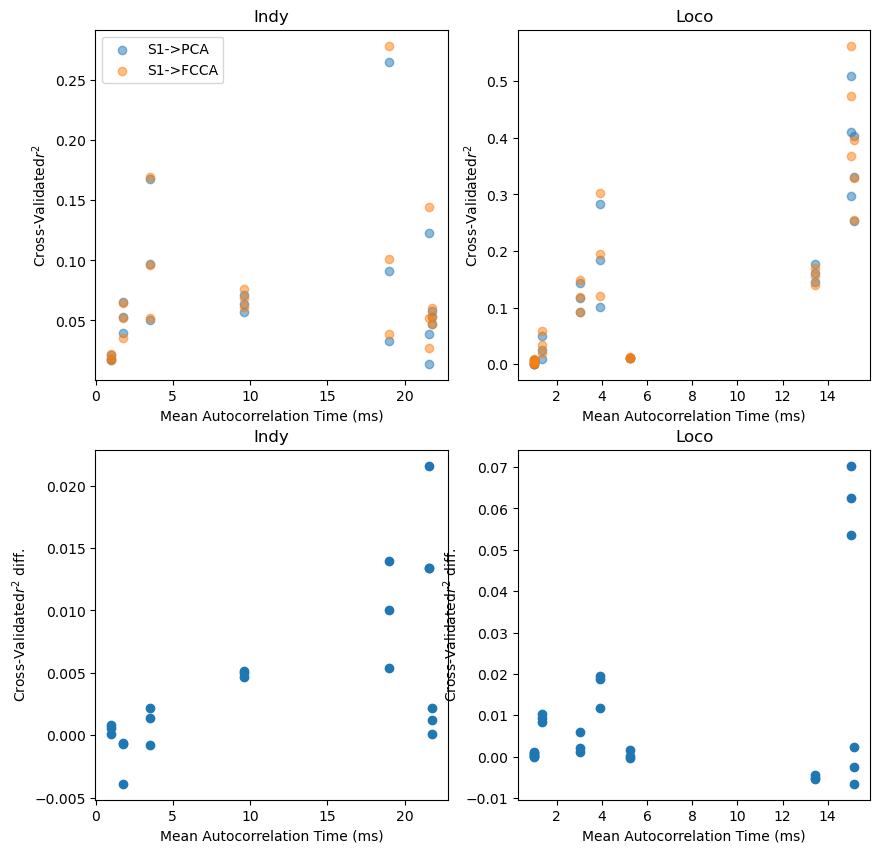

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#r2_act_pairs[r2_act_pairs < -1] = np.nan

ax[0, 0].scatter(sr2_act_pairs[0, :, 4], sr2_act_pairs[0, :, 0], alpha=0.5)
ax[0, 0].scatter(sr2_act_pairs[0, :, 4], sr2_act_pairs[0, :, 1], alpha=0.5)
ax[0, 1].scatter(sr2_act_pairs[1, :, 4], sr2_act_pairs[1, :, 0], alpha=0.5)
ax[0, 1].scatter(sr2_act_pairs[1, :, 4], sr2_act_pairs[1, :, 1], alpha=0.5)

ax[0, 0].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 1].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 0].set_title('Indy')
ax[0, 1].set_title('Loco')
ax[0, 0].legend(['S1->PCA', 'S1->FCCA'])

ax[1, 0].scatter(sr2_act_pairs[0, :, 4], sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0])
ax[1, 1].scatter(sr2_act_pairs[1, :, 4], sr2_act_pairs[1, :, 1] - sr2_act_pairs[1, :, 0])

ax[1, 0].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 1].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 0].set_title('Indy')
ax[1, 1].set_title('Loco')

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/s1m1r2_subspaces.pdf', bbox_inches='tight',  pad_inches=0)

In [ ]:
# What about bin size 50 ms?

In [77]:
# Prediction of subspace activity from the M1 CC vector

In [44]:
w1df = apply_df_filters(dfvalid, win=1)
cc2ssr2 = np.zeros((w1df.shape[0], 4, 5))
dim = 6
for i in tqdm(range(w1df.shape[0])):
    with open(w1df.iloc[i]['fl'], 'rb') as f:
        datM1 = pickle.load(f)
        datS1 = pickle.load(f)
        lparam = pickle.load(f)

    y = datM1['spike_rates'].squeeze()
    x = datS1['spike_rates'].squeeze()

    lag = w1df.iloc[i]['lag']
    w = w1df.iloc[i]['win']
    
    model = w1df.iloc[i]['ccamodel']
    X_c, Y_c = model.transform(x, y)

    # Get the subspaces
    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=w1df.iloc[i]['fl'], dr_method='PCA')

    assert(pcadf.shape[0] == 1)

    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)

    if drdf.empty:
        cc2ssr2[i, 0, :] = np.nan
    else:        
        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        for fold in range(5):
            d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
            Vpca = d_.iloc[0]['coef']

            # M1 CCA
            xtrain = Y_c[d_.iloc[0]['train_idxs']]
            xtest = Y_c[d_.iloc[0]['test_idxs']]

            # M1 PCA
            ytrain = y[d_.iloc[0]['train_idxs']] @ Vpca
            ytest = y[d_.iloc[0]['test_idxs']] @ Vpca


            # Apply window and lag relative to each other
            if lag != 0:
                xtrain = xtrain[:-lag, :]
                xtest = xtest[:-lag, :]

                ytrain = ytrain[lag:, :]  
                ytest = ytest[lag:, :]

            ytrain = StandardScaler().fit_transform(ytrain)
            xtrain = StandardScaler().fit_transform(xtrain)

            ytest = StandardScaler().fit_transform(ytest)
            xtest = StandardScaler().fit_transform(xtest)

            linmodel = RidgeCV()
            linmodel.fit(xtrain, ytrain)
            cc2ssr2[i, 0, fold] = linmodel.score(xtest, ytest)

    lqgdf = apply_df_filters(ref_df, data_file=w1df.iloc[i]['fl'], dr_method='LQGCA')
    assert(lqgdf.shape[0] == 3)

    # Keep consistent ordering of dimreduc args
    drargs = [{'T':3, 'loss_type':'trace', 'n_init':10}, {'T':1, 'loss_type':'trace', 'n_init':10},
              {'T':6, 'loss_type':'trace', 'n_init':10}]

    for j in range(3): 
        lqgdf_ = apply_df_filters(lqgdf, dr_args=drargs[j])
        with open(lqgdf_.iloc[0]['rf'], 'rb') as f:
            results = pickle.load(f)

        drdf = pd.DataFrame(results)
        if drdf.empty:
            cc2ssr2[i, j + 1, :] = np.nan
        else:
            for fold in range(5):
                d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
                if d_.shape[0] == 0:
                    cc2ssr2[i, j, fold] = np.nan
                    continue

                Vlqg = d_.iloc[0]['coef']
                # M1 CCA
                xtrain = Y_c[d_.iloc[0]['train_idxs']]
                xtest = Y_c[d_.iloc[0]['test_idxs']]

                ytrain = y[d_.iloc[0]['train_idxs']] @ Vlqg
                ytest = y[d_.iloc[0]['test_idxs']] @ Vlqg

                # Apply window and lag relative to each other
                if lag != 0:
                    xtrain = xtrain[:-lag, :]
                    xtest = xtest[:-lag, :]

                    ytrain = ytrain[lag:, :]  
                    ytest = ytest[lag:, :]

                ytrain = StandardScaler().fit_transform(ytrain)
                xtrain = StandardScaler().fit_transform(xtrain)

                ytest = StandardScaler().fit_transform(ytest)
                xtest = StandardScaler().fit_transform(xtest)

                linmodel = RidgeCV()
                linmodel.fit(xtrain, ytrain)
                cc2ssr2[i, j + 1, fold] = linmodel.score(xtest, ytest)


100%|██████████| 54/54 [02:52<00:00,  3.20s/it]


In [47]:
# we messed up window function so for now restrict analysis to window size 1
w1df = apply_df_filters(dfvalid, win=1)
sr2_act_pairs = np.zeros((2, w1df.shape[0]//2, 6, 5))

lag_cols = ['r', 'k', 'b']
#win_markers = ['s', 't', 'o']
#win_cols = ['r', 'g', 'b']

cols1 = []
cols2 = []
for j in range(2):
    cols1.append([])
    w1dfd = apply_df_filters(w1df, didx=j, reset_index=False)
    for i in range(w1dfd.shape[0]):
        acf_df_ = apply_df_filters(acfdf, didx=w1dfd.iloc[i]['didx'], bin_width=w1dfd.iloc[i]['bin_width'], filter_fn=w1dfd.iloc[i]['filter_fn'], filter_kwargs=w1dfd.iloc[i]['filter_kwargs'])
        assert(acf_df_.shape[0] == 1)
        sr2_act_pairs[j, i, 0, :] = cc2ssr2[w1dfd.index[i], 0, :]
        sr2_act_pairs[j, i, 1, :] = cc2ssr2[w1dfd.index[i], 1, :]
        sr2_act_pairs[j, i, 2, :] = cc2ssr2[w1dfd.index[i], 2, :]
        sr2_act_pairs[j, i, 3, :] = cc2ssr2[w1dfd.index[i], 3, :]

        sr2_act_pairs[j, i, 4, 0] = np.mean(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))
        sr2_act_pairs[j, i, 5, 0] = np.median(np.concatenate([acf_df_.iloc[0]['M1act'], acf_df_.iloc[0]['S1act']]))


        cols1[j].append(lag_cols[lags.index(w1dfd.iloc[i]['lag'])])

/tmp/ipykernel_8719/419360718.py:5: RuntimeWarning: Mean of empty slice
  ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 0, :], axis=-1), alpha=0.5, fmt='o')
/tmp/ipykernel_8719/419360718.py:6: RuntimeWarning: Mean of empty slice
  ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1, :], axis=-1), alpha=0.5, fmt='o')
/tmp/ipykernel_8719/419360718.py:7: RuntimeWarning: Mean of empty slice
  ax[0, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 0, :], axis=-1), alpha=0.5, fmt='o')
/tmp/ipykernel_8719/419360718.py:18: RuntimeWarning: Mean of empty slice
  ax[1, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), fmt='o')
/tmp/ipyke

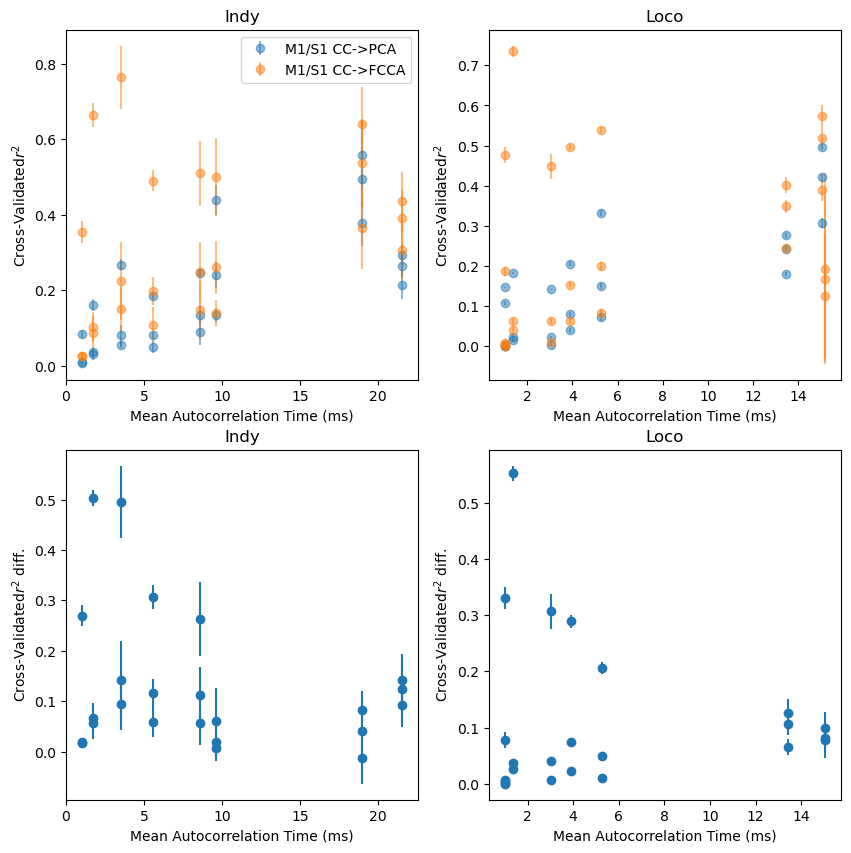

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sr2_act_pairs[sr2_act_pairs < -1] = np.nan

ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 0, :], axis=-1), alpha=0.5, fmt='o')
ax[0, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1, :], axis=-1), alpha=0.5, fmt='o')
ax[0, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 0, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 0, :], axis=-1), alpha=0.5, fmt='o')
ax[0, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 1, :], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 1, :], axis=-1), alpha=0.5, fmt='o')

ax[0, 0].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 1].set_ylabel('Cross-Validated' + r'$r^2$')
ax[0, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[0, 0].set_title('Indy')
ax[0, 1].set_title('Loco')
ax[0, 0].legend(['M1/S1 CC->PCA', 'M1/S1 CC->FCCA'])

ax[1, 0].errorbar(sr2_act_pairs[0, :, 4, 0], np.nanmean(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), yerr=np.nanstd(sr2_act_pairs[0, :, 1] - sr2_act_pairs[0, :, 0], axis=-1), fmt='o')
ax[1, 1].errorbar(sr2_act_pairs[1, :, 4, 0], np.nanmean(sr2_act_pairs[1, :, 1] - sr2_act_pairs[1, :, 0], axis=-1), yerr=np.nanstd(sr2_act_pairs[1, :, 1] - sr2_act_pairs[1, :, 0], axis=-1), fmt='o')

ax[1, 0].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 1].set_ylabel('Cross-Validated' + r'$r^2$ diff.')
ax[1, 0].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 1].set_xlabel('Mean Autocorrelation Time (ms)')
ax[1, 0].set_title('Indy')
ax[1, 1].set_title('Loco')

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/s1m1ccr2_subspaces.pdf', bbox_inches='tight',  pad_inches=0)

In [ ]:
# Scatter plots of the leverage scores of top canonical correlate vs. the FCA/PCA leverage scores.

In [61]:
dfvalid1 = apply_df_filters(df, filter_fn='none', bin_width=[25], win=1, lag=0)
dfvalid2 = apply_df_filters(df, filter_fn='gaussian', filter_kwargs={'sigma': 3}, win=1, lag=0)
dfvalid = pd.concat([dfvalid1, dfvalid2])

In [62]:
dfvalid.shape

(8, 10)

In [63]:
from utils import calc_loadings

In [64]:
w1df = apply_df_filters(dfvalid, win=1)
cc2ssr2 = np.zeros((w1df.shape[0], 4, 5))
dim = 6

rl = []

for i in tqdm(range(dfvalid.shape[0])):
    r = {}
    model = dfvalid.iloc[i]['ccamodel']

    r['cca_loadings'] = calc_loadings(model.y_weights_)
    # Get the subspaces
    # Grab the files specific to the 
    pcadf = apply_df_filters(ref_df, data_file=w1df.iloc[i]['fl'], dr_method='PCA')
    assert(pcadf.shape[0] == 1)
    with open(pcadf.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)
    if drdf.empty:
        r['pca_loadings'] = np.nan
    else:        
        # For each fold, and dimensions 2-6, measure the min and average subspace angle
        pca_loadings = []
        for fold in range(5):
            d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
            Vpca = d_.iloc[0]['coef']
            pca_loadings.append(calc_loadings(Vpca))
        r['pca_loadings'] = np.mean(np.array(pca_loadings), axis=0)

    lqgdf = apply_df_filters(ref_df, data_file=w1df.iloc[i]['fl'], dr_method='LQGCA')
    assert(lqgdf.shape[0] == 3)

    # Keep consistent ordering of dimreduc args
    drargs = {'T':3, 'loss_type':'trace', 'n_init':10}

    lqgdf_ = apply_df_filters(lqgdf, dr_args=drargs)
    with open(lqgdf_.iloc[0]['rf'], 'rb') as f:
        results = pickle.load(f)

    drdf = pd.DataFrame(results)
    if drdf.empty:
        r['lqg_loadings'] = np.nan
    else:
        lqg_loadings = []
        for fold in range(5):
            d_ = apply_df_filters(drdf, dim=dim, fold_idx=fold)
            if d_.shape[0] == 0:
                continue
            else:
                Vlqg = d_.iloc[0]['coef']
                lqg_loadings.append(calc_loadings(Vlqg))
        r['lqg_loadings'] = np.mean(np.array(lqg_loadings), axis=0)

    r['didx'] = dfvalid.iloc[i]['didx']
    r['bin_width'] = dfvalid.iloc[i]['bin_width']
    r['filter_fn'] = dfvalid.iloc[i]['filter_fn']

    rl.append(r)

100%|██████████| 8/8 [00:00<00:00,  8.25it/s]


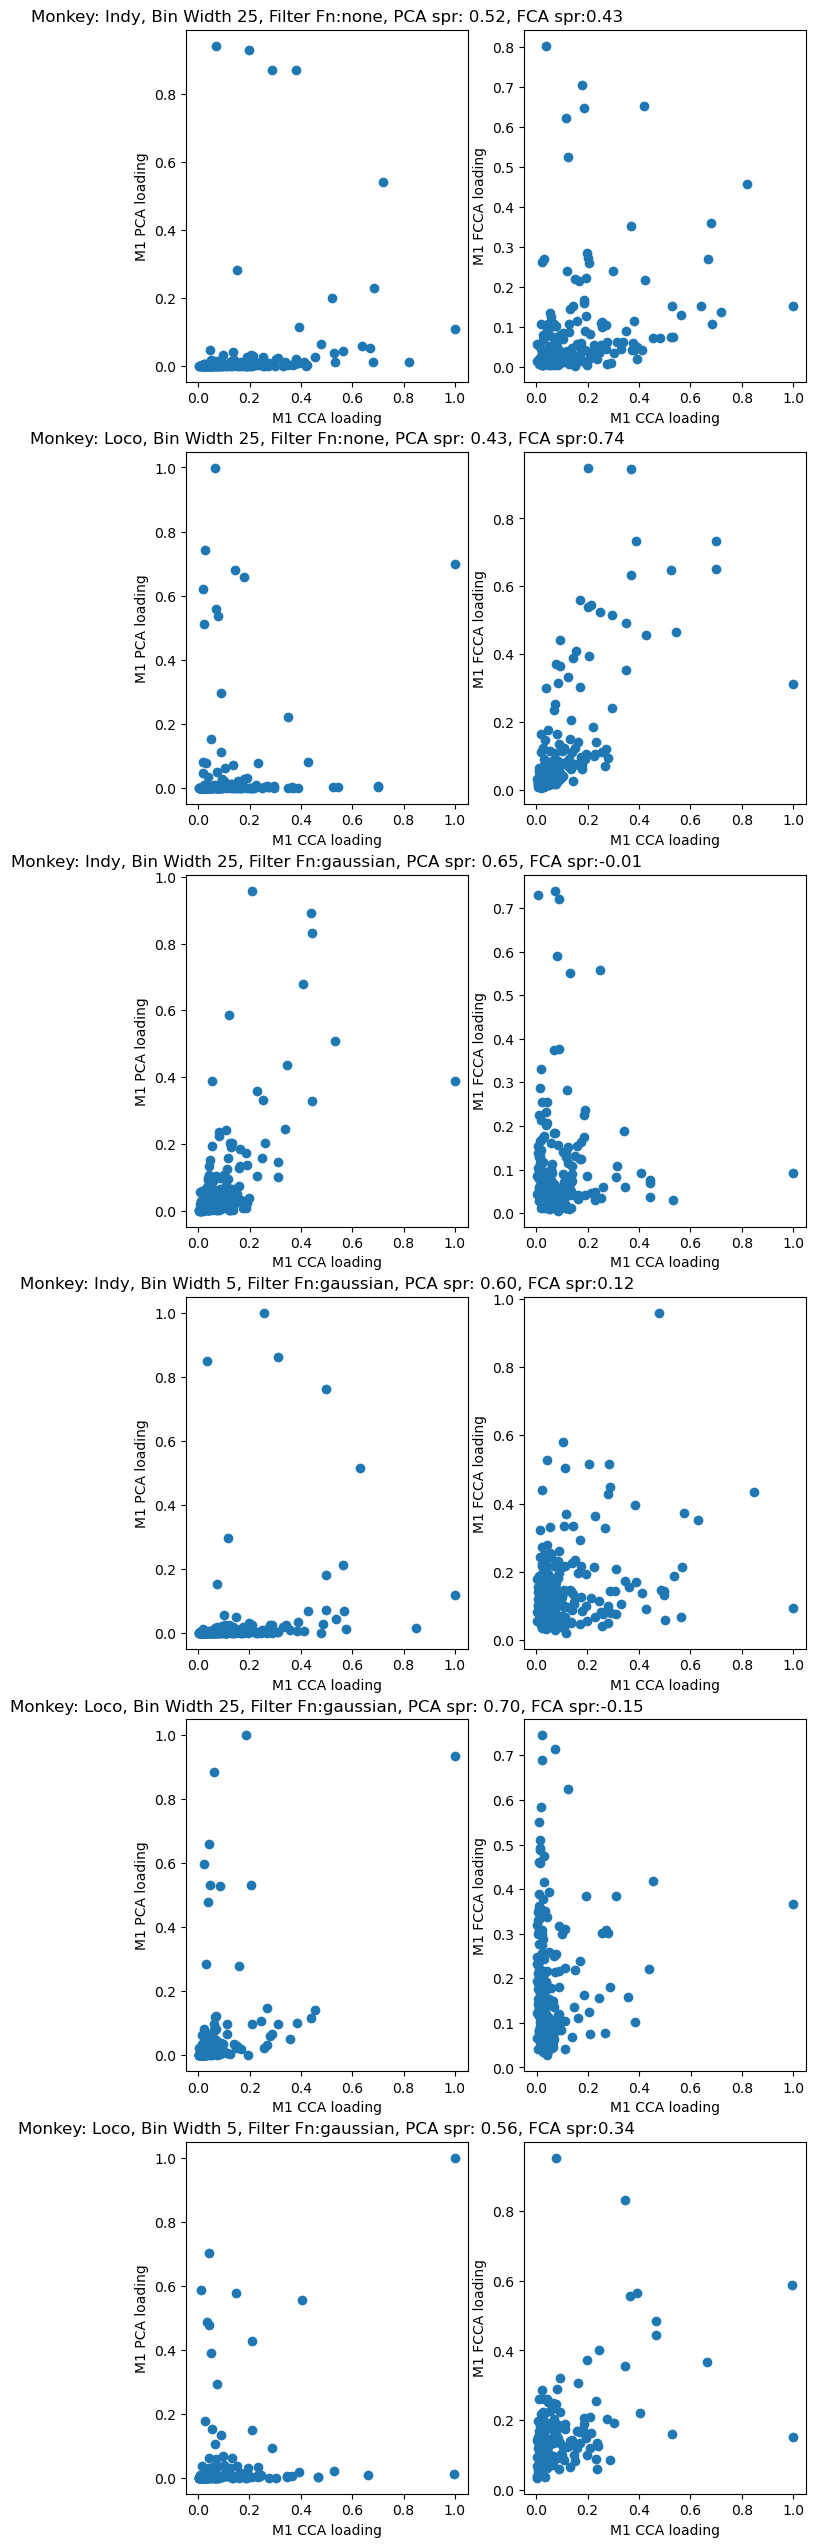

In [74]:
fig, ax = plt.subplots(6, 2, figsize=(8, 32))
for i in range(6):
    if rl[i]['didx'] == 0:
        monkey = 'Indy'
    elif rl[i]['didx'] == 1:
        monkey = 'Loco'

    ax[i, 0].scatter(rl[i]['cca_loadings'], rl[i]['pca_loadings'])
    ax[i, 0].set_xlabel('M1 CCA loading')
    ax[i, 0].set_ylabel('M1 PCA loading')

    ax[i, 1].scatter(rl[i]['cca_loadings'], rl[i]['lqg_loadings'])
    ax[i, 1].set_xlabel('M1 CCA loading')
    ax[i, 1].set_ylabel('M1 FCCA loading')

    r1 = scipy.stats.spearmanr(rl[i]['cca_loadings'], rl[i]['pca_loadings'])[0]
    r2 = scipy.stats.spearmanr(rl[i]['cca_loadings'], rl[i]['lqg_loadings'])[0]

    ax[i, 0].set_title('Monkey: %s, Bin Width %d, Filter Fn:%s, PCA spr: %.2f, FCA spr:%.2f' % (monkey, rl[i]['bin_width'], rl[i]['filter_fn'], r1, r2))

fig.savefig('/home/akumar/nse/neural_control/figs/timescales/cc_ss_loadings.pdf', bbox_inches='tight', pad_inches=0)


In [ ]:
# Recall that we decided we would look at modulations over the timecourse of a reach. Repeat the above exercise accordingly

### Time Resolved

In [8]:
from segmentation import reach_segment_sabes

In [12]:
with open('/mnt/Secondary/data/postprocessed/indy_dimreduc_nocv.dat', 'rb') as f:
    rl = pickle.load(f)

sabes_df = pd.DataFrame(rl)

data_idx = 0
data_file = np.unique(sabes_df['data_file'].values)[data_idx]

dat = load_sabes(data_file)
# dat = reach_segment_sabes(dat, art_times[data_file.split('/')[-1].split('.mat')[0]])

fls = glob.glob('/home/akumar/nse/neural_control/data/s1m1regvt/*.dat')
rl = []
for fl in fls:

    didx = int(fl.split('didx')[1].split('_')[0])
    lidx = int(fl.split('lidx')[1].split('_')[0])
    # dim = int(fl.split('dim')[1].split('_')[0])
    s = fl.split('_')[4:]

    pdb.set_trace()
    filter_params = {}
    filter_params['error_thresh'] = float(s[7])/100
    filter_params['error_op'] = s[-2]
    filter_params['filter_type'] = int(s[1])
    filter_params['op'] = s[3]
    filter_params['q'] = float(s[5])/100

    measure_from_end = bool(int(s[-1].split('.dat')[0]))

    with open(fl, 'rb') as f:
        wr2 = pickle.load(f) 
        error_filter = pickle.load(f)
        reach_filter = pickle.load(f)
        window_filter = pickle.load(f)
        windows = pickle.load(f)
        #filter_params = pickle.load(f)

    result = {}
    result['r2'] = wr2
    result['error_filter'] = error_filter
    result['window_filter'] = window_filter
    result['window'] = np.squeeze(windows)
    result['reach_filter'] = reach_filter
    result['didx'] = didx
    result['dim'] = 6
    result['measure_from_end'] = measure_from_end

    for k, v in filter_params.items():
        result[k] = v
    
    rl.append(result)
dvt_df = pd.DataFrame(rl)

> /tmp/ipykernel_11221/1319741674.py(22)<cell line: 14>()
     20 
     21     pdb.set_trace()
---> 22     filter_params = {}
     23     filter_params['error_thresh'] = float(s[7])/100
     24     filter_params['error_op'] = s[-2]

['rf', '0', 'op', 'le', 'q', '0', 'et', '100', 'eop', 'le', '0.dat']
